In [1]:
# Load libraries
# !pip install -r /work/NLP_IMDb_Exam/requirements.txt
import numpy as np
import pandas as pd
import torch
import datasets
import evaluate
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

2024-12-31 13:32:37.686181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735648357.699157    7170 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735648357.703124    7170 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 13:32:37.718011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
model_dict= {
    1 :{
        "name" : "MiniLM_L6",
        "huggingface" : "sentence-transformers/all-MiniLM-L6-v2",
        },

    2 :{
        "name" : "MPNET_base",
        "huggingface" : 'sentence-transformers/all-mpnet-base-v2',
        },    

    3 :{
        "name" : "Instructor",
        "huggingface" : "hkunlp/instructor-large",
    },}

rating_type={
    1 : "average_rating",
    2 : "rating",
}


# Choose a model for a pseudo-function
Chosen_Model= 2
Rating_to_Drop = 1

# Read embeddings from CSV 
# Corrected
print("1/3")
data_path = f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_corrected.csv'
Corrected_Subspace=pd.read_csv(data_path)
Corrected_Subspace=Corrected_Subspace.drop(columns=[rating_type[Rating_to_Drop]])
model_dict[Chosen_Model]['IMDb'] = Corrected_Subspace

print("2/3")
# GPT Corrected
data_path = f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_GPT_corrected.csv'
GPT_Corrected_Subspace=pd.read_csv(data_path)
GPT_Corrected_Subspace=GPT_Corrected_Subspace.drop(columns=[rating_type[Rating_to_Drop]])
model_dict[Chosen_Model]['GPT'] = GPT_Corrected_Subspace

print("3/3")
# Yelp Corrected
data_path = f'../Data/{model_dict[Chosen_Model]["name"]}/{model_dict[Chosen_Model]["name"]}_yelp_corrected.csv'

Yelp_Corrected_Subspace=pd.read_csv(data_path)
Yelp_Corrected_Subspace=Yelp_Corrected_Subspace.drop(columns=[rating_type[Rating_to_Drop]])
model_dict[Chosen_Model]['Yelp'] = Yelp_Corrected_Subspace

1/3
2/3
3/3


In [33]:
def split_for_training(dataframe):
    """Prepare dataframe for regression
    Args:
        dataframe: pandas dataframe (D, M), the matrix consisting of D-1 independent variable, for M datapoints, and the dataframe.iloc[:,-1] is the dependent variable.
    
    Returns:
        train_features: ndarray of independent training features
        train_labels: ndarray of dependent variable for training 
        eval_features: ndarray of independent evaluation features
        eval_labels: ndarray of dependent variable for training 
    """
    split = train_test_split(dataframe, train_size=0.7)
    finaleval=split[1]
    subset=split[0]

    train_features = subset.iloc[:,0:-1].to_numpy()
    train_labels = np.float32(subset.iloc[:,-1:].to_numpy())
    eval_features = finaleval.iloc[:,0:-1].to_numpy()
    eval_labels = np.float32(finaleval.iloc[:,-1:].to_numpy())

    return train_features, train_labels, eval_features, eval_labels

# Create a linear regression of entire embedding space:

In [34]:
def linear_regression(train_features, train_labels, eval_features, eval_labels):
    """
    Perform regression and return results, summary, and model.

    Args:
        train_features: ndarray of independent training features
        train_labels: ndarray of dependent variable for training 
        eval_features: ndarray of independent evaluation features
        eval_labels: ndarray of dependent variable for training 

    Returns:
        results: DataFrame containing True and Predicted Labels
        summary: Dictionary containing R-squared, MSE, Correlation
        model: The trained regression model
    """
    import statsmodels.api as sm
    import numpy as np
    import pandas as pd

    # Regression Model
    X = sm.add_constant(train_features)  # adding a constant
    model = sm.OLS(train_labels, X).fit()

    # Predictive accuracy
    X_test = sm.add_constant(eval_features)  # add intercept to test_data
    predictions = model.predict(X_test)  # predict

    # Flatten eval_labels if necessary
    eval_labels = eval_labels.ravel()

    # Create DataFrame with true and predicted labels
    results = pd.DataFrame({
        'True Labels': eval_labels,
        'Predicted Labels': predictions
    })

    # Compute additional statistics
    mse = np.mean((results['True Labels'] - results['Predicted Labels'])**2)
    correlation = results.corr().iloc[0, 1]
    r_squared = model.rsquared

    # Return a summary as a dictionary
    summary = {
        "R-squared": r_squared,
        "MSE": mse,
        "Correlation": correlation
    }

    return results, summary, model

In [35]:
def pipeline(dataframe):
    train_features, train_labels, eval_features, eval_labels= split_for_training(dataframe = dataframe)
    results, summary, model = linear_regression(train_features, train_labels, eval_features, eval_labels)
    return results, summary, model
    

In [36]:
# Dictionary for models and tasks
Keys_For_Loop = {
    1: "IMDb",
    2: "GPT",
    3: "Yelp",
}

# Initialize a list to store summaries and a dictionary for models
summaries = []
model_outputs = {}

# Iterate through the dictionary
for i, key in Keys_For_Loop.items():
    print(f"Fitting model: {key}")
    # Assuming Chosen_Model is dynamically set for each task
    data = model_dict[Chosen_Model][key].iloc[:,-2:]  # Assuming model_dict maps keys like "IMDb" to their datasets
    results, summary, model = pipeline(data)  # Assuming pipeline is a defined function returning results
    # Add the model name to the summary and append to the list
    summary["Model Name"] = key
    summaries.append(summary)
    model_outputs[i] = model

# Convert the list of summaries into a DataFrame
summary_df = pd.DataFrame(summaries)

# Display the combined summary
print("Summary of All Models:")
print(summary_df)

Fitting model: IMDb
Fitting model: GPT
Fitting model: Yelp
Summary of All Models:
   R-squared       MSE  Correlation Model Name
0   0.497131  4.162707     0.708128       IMDb
1   0.458833  4.573974     0.673264        GPT
2   0.419237  4.789107     0.649897       Yelp


In [10]:
print(f"Raw parameters (Intercept, slope): {model_outputs[2].params}")
print(f"Standardized parameters (Intercept, slope): {model_outputs[3].params}")


Raw parameters (Intercept, slope): [ 7.04045552 26.70007145]
Standardized parameters (Intercept, slope): [7.16333581 2.36753986]


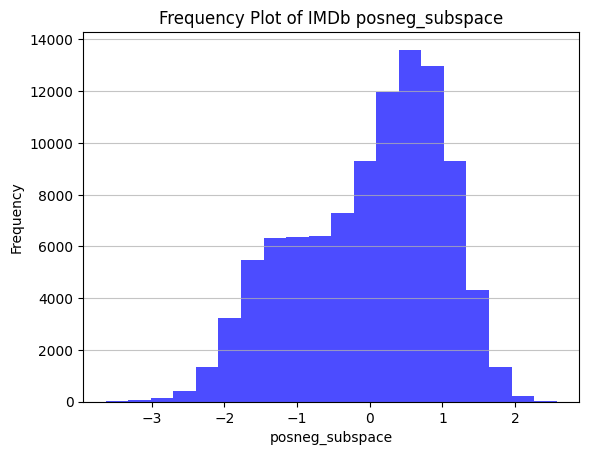

In [11]:
import matplotlib.pyplot as plt
# plot
plt.hist(standard_df["posneg_subspace"], bins=20, color='blue', alpha=0.7)
plt.title("Frequency Plot of IMDb posneg_subspace")
plt.xlabel("posneg_subspace")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [12]:
standard_df

,posneg_subspace,rating
0,0.670839,8
1,-0.198132,9
2,-1.010410,3
3,0.111480,9
4,0.348136,10
...,...,...
99995,0.206998,1
99996,0.553540,10
99997,1.069465,10
99998,1.610154,10


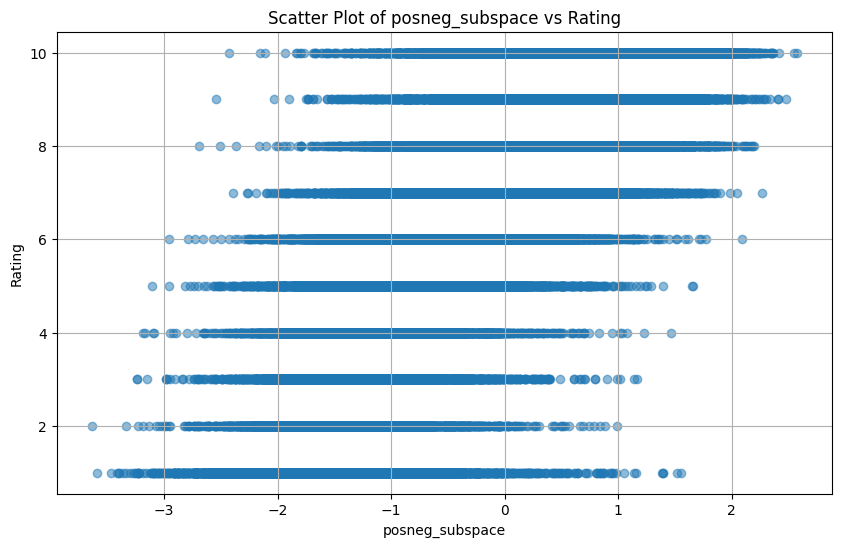

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(standard_df['posneg_subspace'], standard_df['rating'], alpha=0.5)
plt.title("Scatter Plot of posneg_subspace vs Rating")
plt.xlabel("posneg_subspace")
plt.ylabel("Rating")
plt.grid(True)
plt.show()


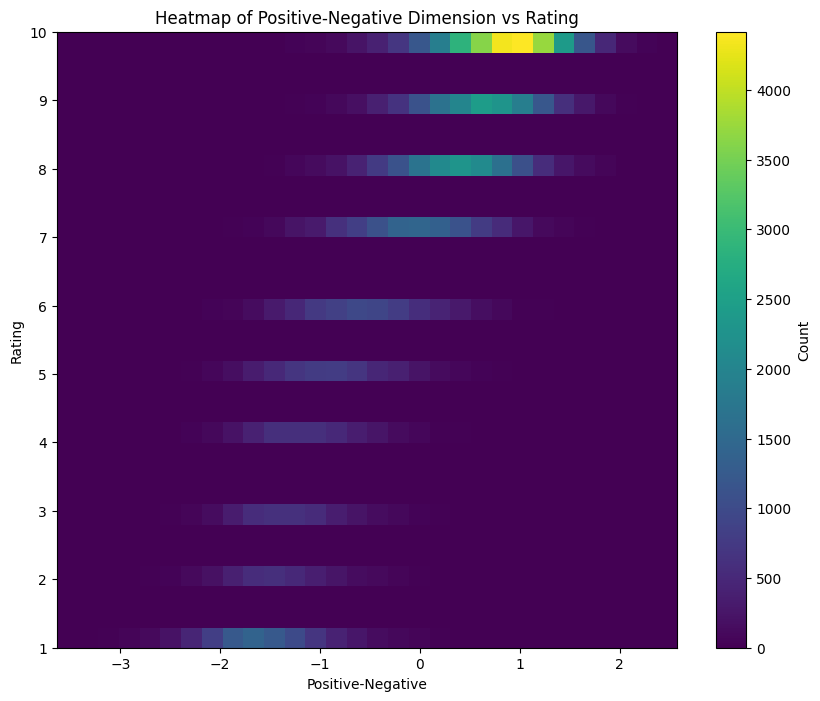

In [35]:
import numpy as np

# Create a 2D histogram for heatmap
heatmap_data, xedges, yedges = np.histogram2d(standard_df['posneg_subspace'], standard_df['rating'], bins=(30, 30))
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data.T, origin='lower', cmap='viridis', aspect='auto',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Count')
plt.title("Heatmap of Positive-Negative Dimension vs Rating")
plt.xlabel("Positive-Negative")
plt.ylabel("Rating")
plt.show()

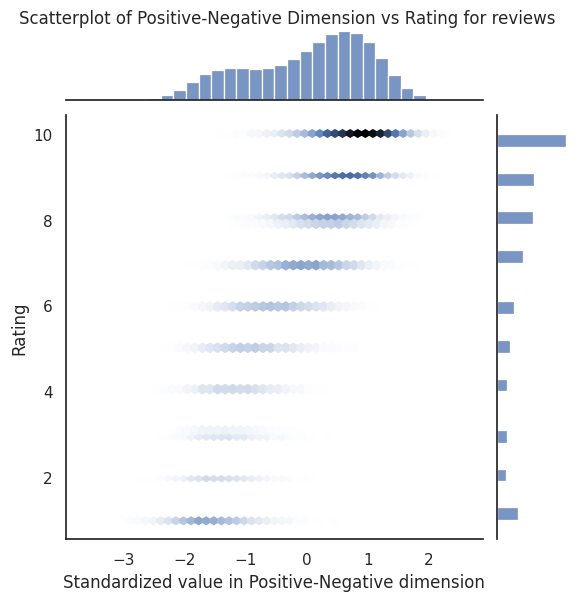

In [41]:
# Plotting
sns.set(style="white")

# Create a jointplot with a 2D histogram
g = sns.jointplot(
    data=standard_df,
    x="posneg_subspace",
    y="rating",
    kind="hex",  # 2D histogram (alternatively, use 'kde' for smooth density)
    marginal_kws={"bins": 30, "fill": True},  # Histogram settings for marginals
)

# Customizing
g.ax_joint.set_xlabel("Standardized value in Positive-Negative dimension", fontsize=12)
g.ax_joint.set_ylabel("Rating", fontsize=12)
g.fig.suptitle("Scatterplot of Positive-Negative Dimension vs Rating for reviews", fontsize=12, y=1)

# Show plot
plt.show()

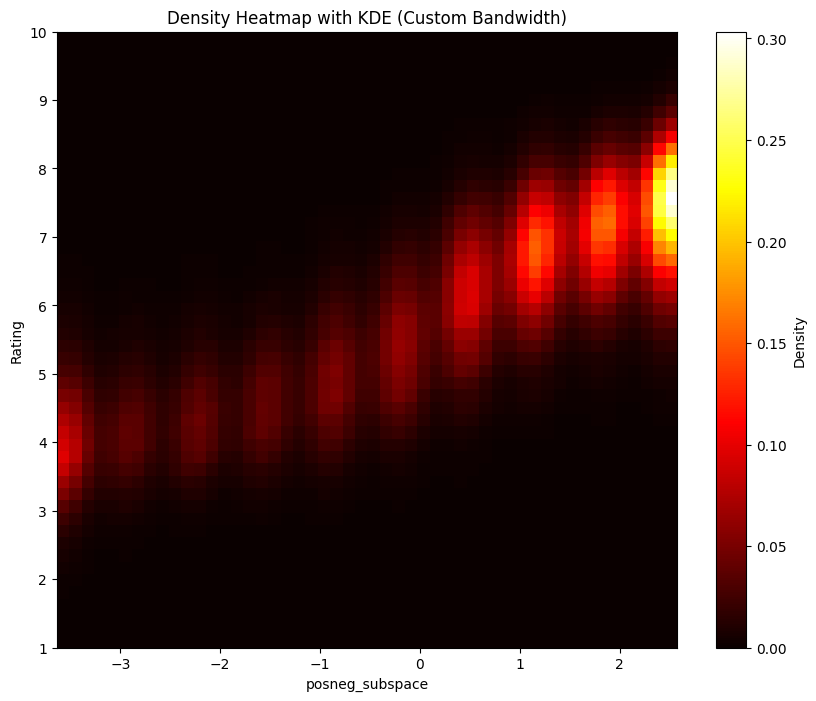

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate sample data (replace with your DataFrame values)
posneg_subspace = standard_df['posneg_subspace']
rating = standard_df['rating']

# Create a 2D grid
x = np.linspace(posneg_subspace.min(), posneg_subspace.max(), 50)
y = np.linspace(rating.min(), rating.max(), 50)
x_grid, y_grid = np.meshgrid(x, y)
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Combine the data into a single array
values = np.vstack([posneg_subspace, rating])

# Perform a 2D kernel density estimation with custom bandwidth
# Smaller bandwidth punishes values farther away more
bandwidth = 0.1  # Adjust this value as needed
kde = gaussian_kde(values, bw_method=bandwidth)
density = kde(positions).reshape(x_grid.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(density.T, origin='lower', cmap='hot', aspect='auto',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar(label='Density')
plt.title("Density Heatmap with KDE (Custom Bandwidth)")
plt.xlabel("posneg_subspace")
plt.ylabel("Rating")
plt.show()


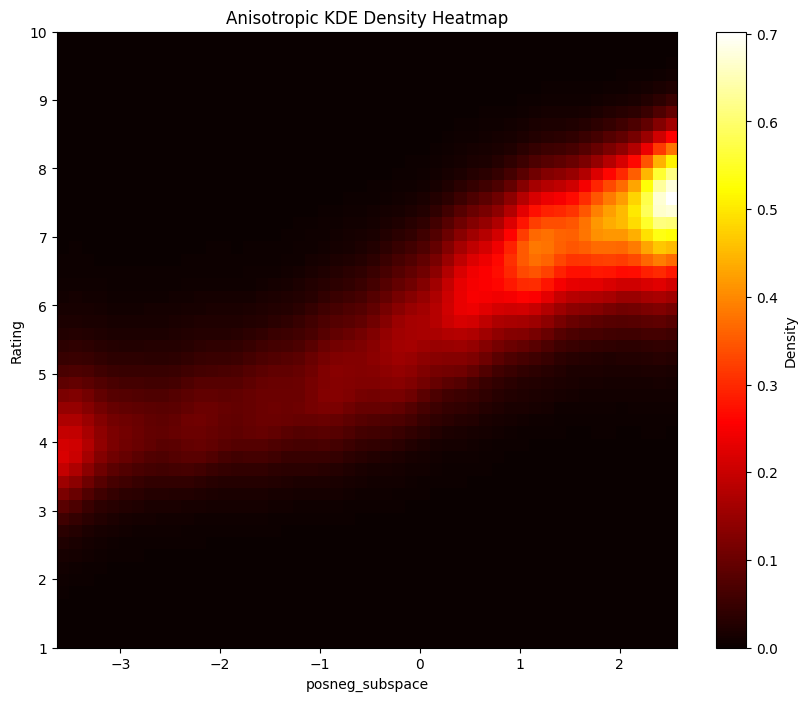

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Extract columns
posneg_subspace = standard_df['posneg_subspace']
rating = standard_df['rating']

# Scale the dimensions differently to reduce smoothness in 'rating'
scale_posneg = 1.0  # Keep original scaling for 'posneg_subspace'
scale_rating = 0.3  # Reduce smoothness in 'rating'

# Transform the data to apply anisotropic scaling
scaled_data = np.vstack([posneg_subspace * scale_posneg, rating * scale_rating])

# Perform KDE on scaled data
kde = gaussian_kde(scaled_data)

# Create a grid for plotting
x = np.linspace(posneg_subspace.min(), posneg_subspace.max(), 50)
y = np.linspace(rating.min(), rating.max(), 50)
x_grid, y_grid = np.meshgrid(x, y)
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Transform the grid for KDE evaluation
scaled_positions = np.vstack([positions[0] * scale_posneg, positions[1] * scale_rating])
density = kde(scaled_positions).reshape(x_grid.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(density.T, origin='lower', cmap='hot', aspect='auto',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar(label='Density')
plt.title("Anisotropic KDE Density Heatmap")
plt.xlabel("posneg_subspace")
plt.ylabel("Rating")
plt.show()


In [8]:
string = "AGGTAT"
string[::-1]

'TATGGA'